# ExampleWorkbook3 
#### Outline of topics:

1. Introduction to Pandas
2. Introduction to Data scraping 
3. Weather data analytics

#### Some useful background material:

The <a href="https://the-examples-book.com/book/introduction" target="_blank">Purdue Data Mine Examples Book</a> contains many useful chapters on data science. While they have not been directly designed for this class, they may be useful. You will not need to use scholar to perform the exercises of this class so don't worry about that part. Here is a direct link to the <a href="https://the-examples-book.com/book/python/introduction" target="_blank">Python chapter.</a>


Additional useful links for Python include:

<a href="https://docs.python.org/3/" target="_blank">Python 3.9.4 documentation</a>

The <a href="https://pypi.org/" target="_blank">Python Package Index</a> (This contains many of the useful Python "add-on" packages such as the math package)

The <a href="https://numpy.org/" target="_blank">Numpy Package</a> (This contains specialized array (vector and matrix) routines. Numpy stands for "Numerical Python")

The <a href="https://pandas.pydata.org/docs/" target="_blank">Pandas Documentation</a> (Open source data analysis and manipulation tool, built on top of the Python programming language)  

The <a href="https://requests.readthedocs.io/en/latest/" target="_blank">Requests Documentation</a> (An elegant and simple HTTP library for Python, built for human beings)  


In this notebook we will download ACIS / PRISM gridded weather data and use it to compute GDU curves at a specific field. It is the start of a data processing scheme that brings insight into field state and operational planning.


**Note:** The matplotlib style to “seaborn”, but you can choose others.

In [5]:
import requests
import pandas as pd
import numpy as np

In [6]:
# Setup some plotting styles so that we can have the same style through out workbook
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt # This is just so we don't have to type "matplotlib.pyplot" all the time.
import seaborn as sns
sns.set_theme()

plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20, figsize=(15, 8))  # fontsize of the figure title

#### *Discussion 1*: Creating API requests to scrape weather data
Let us start by grabbing some ACIS weather data for a field at Purdue's [ACRE farm](https://www.google.com/maps/place/40%C2%B028'27.2%22N+86%C2%B059'43.7%22W/@40.4742259,-86.9975974,1242m/data=!3m1!1e3!4m5!3m4!1s0x0:0x0!8m2!3d40.4742222!4d-86.9954722). That is GPS coordinate: (40.4742259,-86.9975974).

We will grab all the _historical_ data that ACIS/PRISM has available. 

**Required parameters**  
<img  src="Figs/requiredParametersforgriddeddata.png" width="600">
<!-- ![Required parameters](Figs/requiredParametersforgriddeddata.png) -->  


**ACIS Query builder**  
the query builder is convenient for querying initially. You can try to build a different query.  
<img  src="Figs/ACISQuerybuildercropped.png" width="600">


We are querying complete historical data for Purdue ACRE from the PRISM gridded data model

In [125]:
# GPS coordinates of Purdue ACRE farm
lat = 40.4742259
lon = -86.9975974
# PRISM usally goes back to 1981
sdate = "1981-01-01" #start date for historical data
edate = "2022-12-31" #end date for historical data
# Make ACIS API request
w = requests.post('http://data.rcc-acis.org/GridData', json={
    "loc": f"{lon}, {lat}",
    "sdate": sdate,
    "edate": edate,
    "grid": "21",   # "21" is PRISM
    "elems": [
    # "maxt" is maximum temperature at interval daily in degree Faherenheit and precipitation in inch
        { "name":"maxt", "interval":"dly", "units":"degreeF" }, 
        { "name":"mint", "interval":"dly", "units":"degreeF" },
        { "name":"pcpn", "interval":"dly", "units":"inch" }
    ]  
})
# Parse the JSON response to a Python datatypes
w = w.json()
#use for loop to print the first 10 items in the retrieved weather data
for item in w['data'][0:10]: 
    print("the retrived weather data: ",item)  # Print the first 10 items in the retrieved weather data

the retrived weather data:  ['1981-01-01', 34, 30, 0.0]
the retrived weather data:  ['1981-01-02', 33, 18, 0.0]
the retrived weather data:  ['1981-01-03', 32, 18, 0.0]
the retrived weather data:  ['1981-01-04', 24, -2, 0.0]
the retrived weather data:  ['1981-01-05', 13, -3, 0.0]
the retrived weather data:  ['1981-01-06', 25, -1, 0.12]
the retrived weather data:  ['1981-01-07', 30, 5, 0.1]
the retrived weather data:  ['1981-01-08', 13, -1, 0.0]
the retrived weather data:  ['1981-01-09', 18, -4, 0.0]
the retrived weather data:  ['1981-01-10', 19, -3, 0.0]


#### *Discussion 2*: Introduction to Pandas DataFrame

Pandas DataFrame has row and column labels instead of index. It will have default index column unless specifically assigned a different index column.  

![Pandas DataFrame](Figs/pandasDataframe.png)

In [126]:
# Convert the raw Python map to a Pandas DataFrame
w = pd.DataFrame(w['data'], columns=['date', 'maxt', 'mint', 'pcpn'])

# w.to_csv("acre_weather_data.csv") # you can uncomment this to save the file in this directory

In [127]:
# Convert the date "string" into a real Pandas date object (enables some Pandas niceties)
w['date'] = pd.to_datetime(w['date'])

# Tell Pandas to use the "date" columns as the index. Basically this means it will be easy 
# to select data from the DataFrame by date and date range.
w.set_index('date', inplace=True)

#### *Discussion 3*: Getting comfortable with Pandas:Useful utilities


**Task:** View the first few rows

In [128]:
w.head()


maxt  mint  pcpn
date                        
1981-01-01    34    30   0.0
1981-01-02    33    18   0.0
1981-01-03    32    18   0.0
1981-01-04    24    -2   0.0
1981-01-05    13    -3   0.0

In [130]:
wplantGrowth=w.copy()
wplantGrowth.head()

maxt  mint  pcpn
date                        
1981-01-01    34    30   0.0
1981-01-02    33    18   0.0
1981-01-03    32    18   0.0
1981-01-04    24    -2   0.0
1981-01-05    13    -3   0.0

In [11]:
w.describe()

maxt          mint          pcpn
count  15340.000000  15340.000000  15340.000000
mean      61.340743     41.285463      0.107096
std       21.012896     18.958502      0.289039
min      -11.000000    -24.000000      0.000000
25%       44.000000     28.000000      0.000000
50%       64.000000     42.000000      0.000000
75%       80.000000     57.000000      0.050000
max      103.000000     79.000000      4.490000

**GDU caluclation using temperature data**  
Growing Degree Days, $$gdd= \frac{Tmax+Tmin}{2}-{Tbase}$$  
T<sub>*max*</sub> = maximum temperature of the day  
T<sub>*min*</sub> = minimum temperature of the day  
T<sub>*base*</sub> = minimum temperature that contributes to GDD  

[Degree days description](Documents/CliMate%20-%20Degree%20Days%20Description.pdf)  
accept to install the extension to view it in VSCode  
![VSCode PDF extension](Figs/pdfextension.png)




In [12]:
t_max=84 #maximum temperature for corn growth
t_base=50 #base temperature for corn growth
w["maxt_gd"]=w["maxt"] #create a new column for max temperature for column operations
w["mint_gd"]=w["mint"]#create a new column for min temperature for column operations
w.loc[w.maxt_gd > t_max, 'maxt_gd'] = t_max #set the max temperature to 84 if it is greater than 84

# Save the daily GDU totals back to the DataFrame as a new column
w['gdu'] = (w.maxt_gd + w.mint_gd) / 2 - t_base
# Negative GDUs are assumed to be zero ... that is a colder day doesn't reduce the growth
w.loc[w.gdu < 0, 'gdu'] = 0 
w.describe()

maxt          mint          pcpn       maxt_gd       mint_gd  \
count  15340.000000  15340.000000  15340.000000  15340.000000  15340.000000   
mean      61.340743     41.285463      0.107096     60.704107     41.285463   
std       21.012896     18.958502      0.289039     20.201285     18.958502   
min      -11.000000    -24.000000      0.000000    -11.000000    -24.000000   
25%       44.000000     28.000000      0.000000     44.000000     28.000000   
50%       64.000000     42.000000      0.000000     64.000000     42.000000   
75%       80.000000     57.000000      0.050000     80.000000     57.000000   
max      103.000000     79.000000      4.490000     84.000000     79.000000   

                gdu  
count  15340.000000  
mean       8.801565  
std       10.008090  
min        0.000000  
25%        0.000000  
50%        3.000000  
75%       18.500000  
max       31.500000

In [13]:
w.tail()

maxt  mint  pcpn  maxt_gd  mint_gd  gdu
date                                               
2022-12-27    25    16  0.00       25       16  0.0
2022-12-28    28    16  0.00       28       16  0.0
2022-12-29    50    28  0.00       50       28  0.0
2022-12-30    56    49  0.06       56       49  2.5
2022-12-31    56    35  0.58       56       35  0.0

**Print the column wise statistics of the data** 

In [14]:
w.describe()

maxt          mint          pcpn       maxt_gd       mint_gd  \
count  15340.000000  15340.000000  15340.000000  15340.000000  15340.000000   
mean      61.340743     41.285463      0.107096     60.704107     41.285463   
std       21.012896     18.958502      0.289039     20.201285     18.958502   
min      -11.000000    -24.000000      0.000000    -11.000000    -24.000000   
25%       44.000000     28.000000      0.000000     44.000000     28.000000   
50%       64.000000     42.000000      0.000000     64.000000     42.000000   
75%       80.000000     57.000000      0.050000     80.000000     57.000000   
max      103.000000     79.000000      4.490000     84.000000     79.000000   

                gdu  
count  15340.000000  
mean       8.801565  
std       10.008090  
min        0.000000  
25%        0.000000  
50%        3.000000  
75%       18.500000  
max       31.500000

**Pandas DataFrame Selection, Modification operations using index**

 Select the "date" column

In [15]:
# Error: w['date']
# Error: w.date
w.index

DatetimeIndex(['1981-01-01', '1981-01-02', '1981-01-03', '1981-01-04',
               '1981-01-05', '1981-01-06', '1981-01-07', '1981-01-08',
               '1981-01-09', '1981-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', name='date', length=15340, freq=None)


Select rows 36 through 38

In [16]:
w[36:39]

maxt  mint  pcpn  maxt_gd  mint_gd  gdu
date                                               
1981-02-06    28     2   0.0       28        2  0.0
1981-02-07    33    22   0.0       33       22  0.0
1981-02-08    39    10   0.0       39       10  0.0

 Select rows from March 4th, 1987 to May 6th, 1987

In [17]:
w['1987-03-04':'1987-05-06']

maxt  mint  pcpn  maxt_gd  mint_gd   gdu
date                                                
1987-03-04    47    22  0.00       47       22   0.0
1987-03-05    49    25  0.01       49       25   0.0
1987-03-06    58    33  0.00       58       33   0.0
1987-03-07    69    35  0.00       69       35   2.0
1987-03-08    74    39  0.00       74       39   6.5
...          ...   ...   ...      ...      ...   ...
1987-05-02    74    50  0.00       74       50  12.0
1987-05-03    79    55  0.00       79       55  17.0
1987-05-04    70    40  0.00       70       40   5.0
1987-05-05    67    38  0.00       67       38   2.5
1987-05-06    70    40  0.00       70       40   5.0

[64 rows x 6 columns]

In [18]:
w['2000':'2001']

maxt  mint  pcpn  maxt_gd  mint_gd  gdu
date                                               
2000-01-01    45    24  0.00       45       24  0.0
2000-01-02    56    30  0.00       56       30  0.0
2000-01-03    60    38  0.00       60       38  0.0
2000-01-04    51    29  0.69       51       29  0.0
2000-01-05    31    19  0.00       31       19  0.0
...          ...   ...   ...      ...      ...  ...
2001-12-27    24    10  0.00       24       10  0.0
2001-12-28    34    23  0.00       34       23  0.0
2001-12-29    30    15  0.00       30       15  0.0
2001-12-30    19     7  0.00       19        7  0.0
2001-12-31    24     8  0.00       24        8  0.0

[731 rows x 6 columns]

In [19]:
w['2000-01':'2000-03']

maxt  mint  pcpn  maxt_gd  mint_gd  gdu
date                                               
2000-01-01    45    24  0.00       45       24  0.0
2000-01-02    56    30  0.00       56       30  0.0
2000-01-03    60    38  0.00       60       38  0.0
2000-01-04    51    29  0.69       51       29  0.0
2000-01-05    31    19  0.00       31       19  0.0
...          ...   ...   ...      ...      ...  ...
2000-03-27    67    37  0.13       67       37  2.0
2000-03-28    57    33  0.05       57       33  0.0
2000-03-29    43    33  0.01       43       33  0.0
2000-03-30    54    27  0.00       54       27  0.0
2000-03-31    56    24  0.00       56       24  0.0

[91 rows x 6 columns]

Print the column wise statistics of the data

In [20]:
w.describe()

maxt          mint          pcpn       maxt_gd       mint_gd  \
count  15340.000000  15340.000000  15340.000000  15340.000000  15340.000000   
mean      61.340743     41.285463      0.107096     60.704107     41.285463   
std       21.012896     18.958502      0.289039     20.201285     18.958502   
min      -11.000000    -24.000000      0.000000    -11.000000    -24.000000   
25%       44.000000     28.000000      0.000000     44.000000     28.000000   
50%       64.000000     42.000000      0.000000     64.000000     42.000000   
75%       80.000000     57.000000      0.050000     80.000000     57.000000   
max      103.000000     79.000000      4.490000     84.000000     79.000000   

                gdu  
count  15340.000000  
mean       8.801565  
std       10.008090  
min        0.000000  
25%        0.000000  
50%        3.000000  
75%       18.500000  
max       31.500000


**Task:** Select the entire maximum temperature column

In [21]:
w.maxt

date
1981-01-01    34
1981-01-02    33
1981-01-03    32
1981-01-04    24
1981-01-05    13
              ..
2022-12-27    25
2022-12-28    28
2022-12-29    50
2022-12-30    56
2022-12-31    56
Name: maxt, Length: 15340, dtype: int64

**Task:** Select the "date" column

In [22]:
# Error: w['date']
# Error: w.date
w.index

DatetimeIndex(['1981-01-01', '1981-01-02', '1981-01-03', '1981-01-04',
               '1981-01-05', '1981-01-06', '1981-01-07', '1981-01-08',
               '1981-01-09', '1981-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', name='date', length=15340, freq=None)



**Task:** Select rows 36 through 38

In [23]:
w[36:39]

maxt  mint  pcpn  maxt_gd  mint_gd  gdu
date                                               
1981-02-06    28     2   0.0       28        2  0.0
1981-02-07    33    22   0.0       33       22  0.0
1981-02-08    39    10   0.0       39       10  0.0

**Task:** Select rows from March 4th, 1987 to May 6th, 1987

In [24]:
w['1987-03-04':'1987-05-06']

maxt  mint  pcpn  maxt_gd  mint_gd   gdu
date                                                
1987-03-04    47    22  0.00       47       22   0.0
1987-03-05    49    25  0.01       49       25   0.0
1987-03-06    58    33  0.00       58       33   0.0
1987-03-07    69    35  0.00       69       35   2.0
1987-03-08    74    39  0.00       74       39   6.5
...          ...   ...   ...      ...      ...   ...
1987-05-02    74    50  0.00       74       50  12.0
1987-05-03    79    55  0.00       79       55  17.0
1987-05-04    70    40  0.00       70       40   5.0
1987-05-05    67    38  0.00       67       38   2.5
1987-05-06    70    40  0.00       70       40   5.0

[64 rows x 6 columns]


**Task:** Select the maxt column from Feb 1, 2002 to April 15th, 2002

In [25]:
w['2002-02-01':'2002-04-15']['maxt']

date
2002-02-01    52
2002-02-02    34
2002-02-03    37
2002-02-04    42
2002-02-05    29
              ..
2002-04-11    64
2002-04-12    76
2002-04-13    72
2002-04-14    64
2002-04-15    75
Name: maxt, Length: 74, dtype: int64

**Modifying part of column**

**Task:** Compute each day's average temperature and save it as the new column "avg"

In [26]:
# Let's "copy" the DataFrame so we don't break the data for the rest of the notebook
w_copy = w.copy()

# Compute average temp and save back to the data frame
w_copy['avgt'] = (w_copy.mint + w_copy.maxt) / 2

w_copy.avgt 

date
1981-01-01    32.0
1981-01-02    25.5
1981-01-03    25.0
1981-01-04    11.0
1981-01-05     5.0
              ... 
2022-12-27    20.5
2022-12-28    22.0
2022-12-29    39.0
2022-12-30    52.5
2022-12-31    45.5
Name: avgt, Length: 15340, dtype: float64

**Modifying part of a column in place**

**Task:** Limit the min temp to 0 F. Plot the original and modified data series to prove it worked.

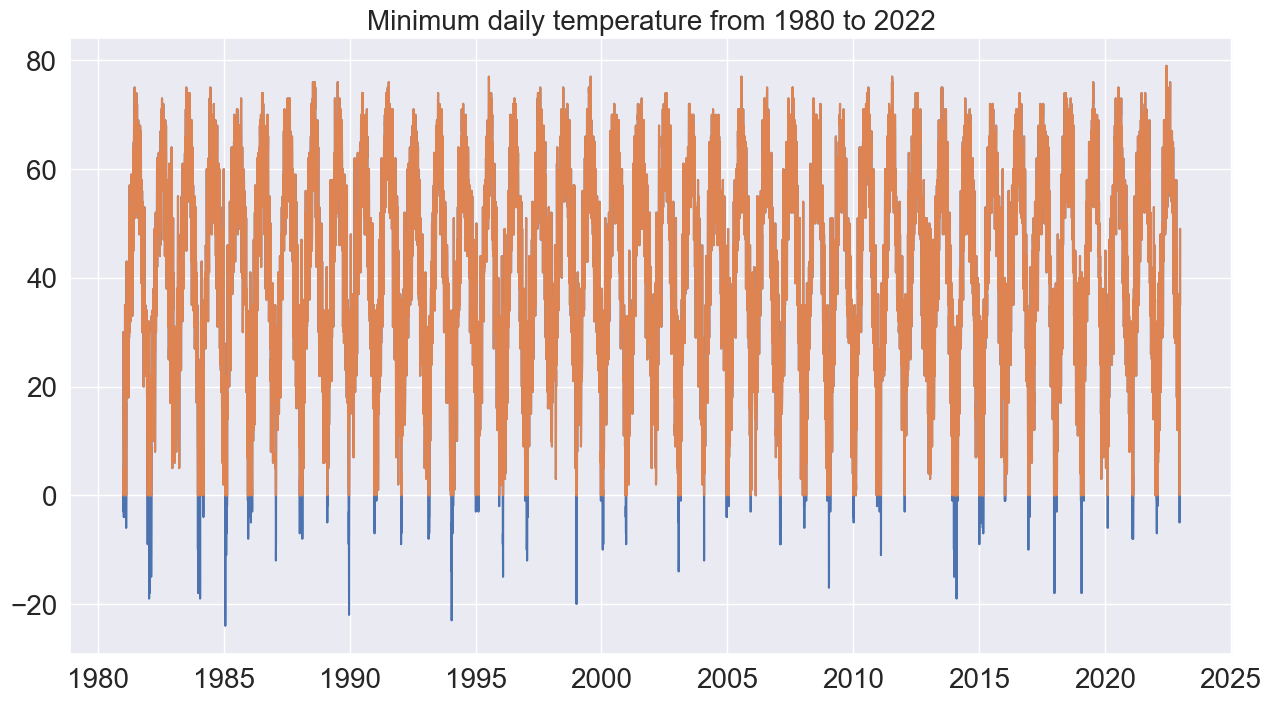

In [27]:
# Select the rows to modify and then modify them.
w_copy.loc[w_copy.mint < 0, 'mint'] = 0

plt.plot(w.mint)
plt.plot(w_copy.mint) 
plt.title("Minimum daily temperature from 1980 to 2022")
plt.show()

#### *Discussion 4*: Grouping and reducing DataFrame

In Pandas, you can group a DataFrame by a field or condition and then apply an operation to each group. The output is a new DataFrame indexed by the "group by" value and with values equal to the return of each operation.

**Task:** Find the maximum precipitation for each year

In [28]:
byYear = w.groupby(w.index.year)

byYear.pcpn.max()
#byYear.gdu.sum()

date
1981    3.74
1982    2.15
1983    3.08
1984    2.13
1985    2.15
1986    2.72
1987    3.44
1988    1.96
1989    2.29
1990    3.79
1991    2.33
1992    2.29
1993    2.21
1994    3.69
1995    2.27
1996    1.97
1997    2.35
1998    1.82
1999    3.18
2000    4.19
2001    2.29
2002    2.05
2003    2.68
2004    4.49
2005    1.55
2006    1.97
2007    2.41
2008    1.94
2009    2.70
2010    3.07
2011    2.70
2012    3.26
2013    2.89
2014    2.18
2015    2.35
2016    2.46
2017    1.86
2018    2.61
2019    1.60
2020    1.94
2021    2.96
2022    2.09
Name: pcpn, dtype: float64

In [29]:
w.head()

maxt  mint  pcpn  maxt_gd  mint_gd  gdu
date                                               
1981-01-01    34    30   0.0       34       30  0.0
1981-01-02    33    18   0.0       33       18  0.0
1981-01-03    32    18   0.0       32       18  0.0
1981-01-04    24    -2   0.0       24       -2  0.0
1981-01-05    13    -3   0.0       13       -3  0.0

**Merge two group reductions**

Find the maximum and minimum temperature for each year

In [30]:
pd.concat([byYear.maxt.max(), byYear.mint.min(), byYear.gdu.max(),byYear.gdu.mean(),byYear.gdu.sum()], axis='columns')

maxt  mint   gdu        gdu     gdu
date                                     
1981    94    -9  29.5   8.294521  3027.5
1982    93   -19  28.5   8.486301  3097.5
1983   100   -18  29.5   8.754795  3195.5
1984    94   -19  29.5   8.342896  3053.5
1985    92   -24  28.5   8.926027  3258.0
1986    94    -5  29.0   9.150685  3340.0
1987    95   -12  28.5   9.153425  3341.0
1988   103    -8  30.0   8.689891  3180.5
1989    95   -22  30.0   8.297260  3028.5
1990    95    -7  29.0   8.436986  3079.5
1991    97    -1  30.0   9.727397  3550.5
1992    96    -9  27.5   7.322404  2680.0
1993    91    -8  29.0   7.891781  2880.5
1994    95   -23  28.0   8.131507  2968.0
1995    98    -3  30.5   8.793151  3209.5
1996    93   -15  28.5   7.704918  2820.0
1997    96   -12  29.5   7.790411  2843.5
1998    96     0  29.5   9.771233  3566.5
1999    99   -20  30.5   8.972603  3275.0
2000    94   -10  28.0   8.969945  3283.0
2001    93     0  28.5   8.995890  3283.5
2002    96     2  29.0   9.034247  3297.5
2003    94   -14  28.0   8.420548  3073.5
2004    90   -12  27.5   8.640710  3162.5
2005    95    -3  30.5   9.373973  3421.5
2006    93     0  29.5   8.553425  3122.0
2007    97    -9  29.5  10.027397  3660.0
2008    91    -6  28.5   8.431694  3086.0
2009    93   -17  28.0   8.171233  2982.5
2010    94    -5  29.5   9.878082  3605.5
2011    99   -11  30.5   8.935616  3261.5
2012   102    -3  29.0   9.532787  3489.0
2013    97    -1  29.5   8.690411  3172.0
2014    91   -19  28.5   7.884932  2878.0
2015    93    -9  28.0   8.901370  3249.0
2016    93   -10  29.0   9.594262  3511.5
2017    92   -10  28.0   8.956164  3269.0
2018    96   -18  29.0   9.498630  3467.0
2019    93   -18  30.0   8.836986  3225.5
2020    92    -6  29.5   8.797814  3220.0
2021    98    -8  29.0   9.913699  3618.5
2022    98    -7  31.5   8.993151  3282.5

In [31]:
byYear_df=pd.concat([byYear.maxt.max(), byYear.mint.min(),byYear.gdu.sum(),byYear.pcpn.sum()], axis='columns')
byYear_df.head()

maxt  mint     gdu   pcpn
date                           
1981    94    -9  3027.5  43.09
1982    93   -19  3097.5  40.44
1983   100   -18  3195.5  33.37
1984    94   -19  3053.5  32.90
1985    92   -24  3258.0  38.56

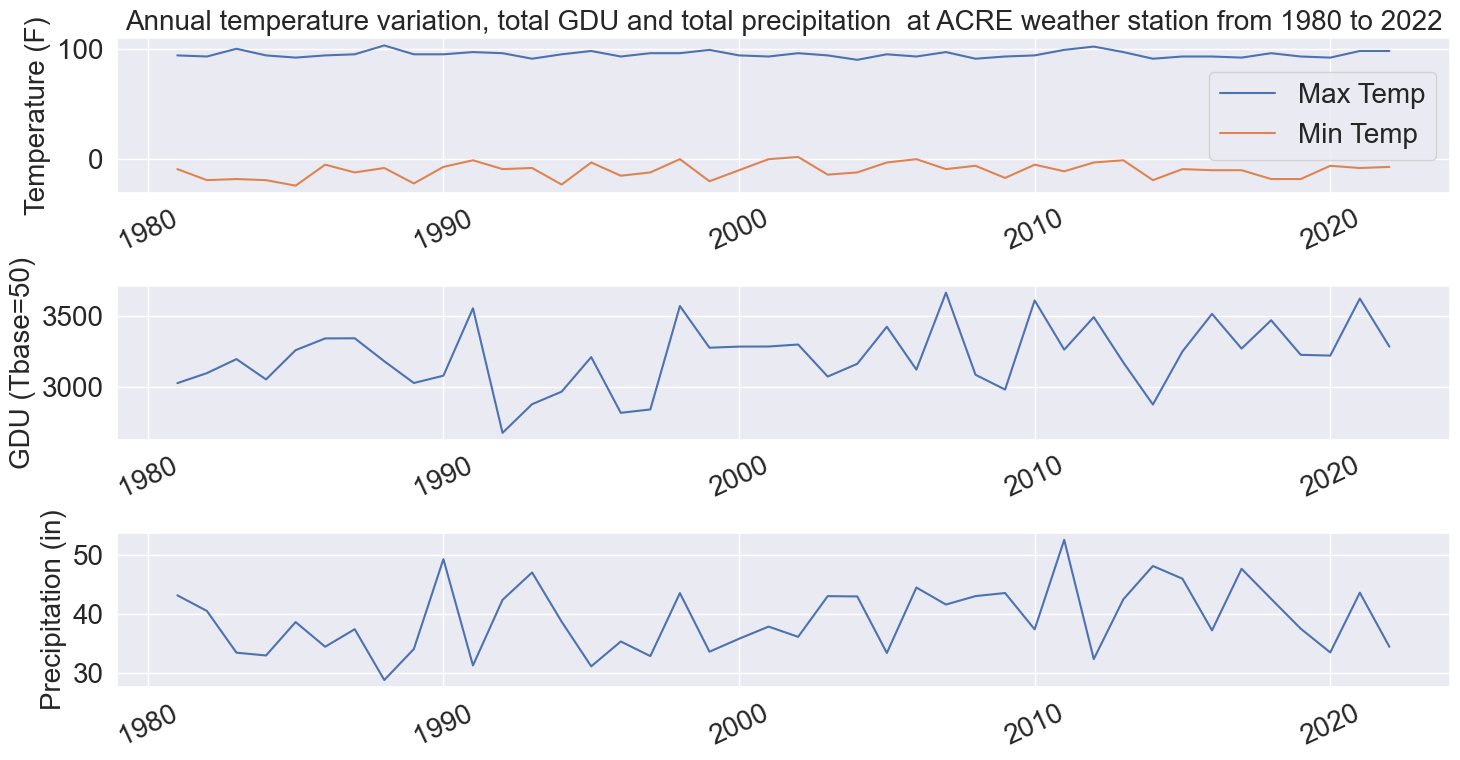

In [32]:
### Put two plots on one figure

# The `subplot` command allows us to slice up one image and draw multiple independent figures into each slice
# In this case, we are slicing the image into 2 rows and 1 column. We select the first slice.
ax = plt.subplot(3, 1, 1)
plt.plot(byYear_df.maxt)
plt.plot(byYear_df.mint)

plt.legend(['Max Temp', 'Min Temp'])
plt.ylabel('Temperature (F)')
plt.title('Annual temperature variation, total GDU and total precipitation  at ACRE weather station from 1980 to 2022')
plt.xticks(rotation=25)

# Now we select the second slice. Notice we share the x-axis. This is so when you interact with the either plot
# the other plot is automatically adjusted to the same scale.
plt.subplot(3, 1, 2, sharex=ax)
plt.plot(byYear_df.gdu)

plt.ylabel('GDU (Tbase=50)')
plt.xticks(rotation=25)

plt.subplot(3, 1, 3, sharex=ax)
plt.plot(byYear_df.pcpn)

plt.ylabel('Precipitation (in)')
plt.xticks(rotation=25)

plt.tight_layout()
plt.show()

In [33]:
w.head()


maxt  mint  pcpn  maxt_gd  mint_gd  gdu
date                                               
1981-01-01    34    30   0.0       34       30  0.0
1981-01-02    33    18   0.0       33       18  0.0
1981-01-03    32    18   0.0       32       18  0.0
1981-01-04    24    -2   0.0       24       -2  0.0
1981-01-05    13    -3   0.0       13       -3  0.0

**Plot grouped DataFrame**

Make an error bar plot of temperature over a year

In [34]:
# Day of year: Jan 1 -> 0, Jan 2 -> 1, Jan 3 -> 2, ... without regard the actual year
byDay = w.groupby(w.index.dayofyear)
byDay.head(20)

maxt  mint  pcpn  maxt_gd  mint_gd  gdu
date                                               
1981-01-01    34    30  0.00       34       30  0.0
1981-01-02    33    18  0.00       33       18  0.0
1981-01-03    32    18  0.00       32       18  0.0
1981-01-04    24    -2  0.00       24       -2  0.0
1981-01-05    13    -3  0.00       13       -3  0.0
...          ...   ...   ...      ...      ...  ...
2004-12-31    57    38  0.02       57       38  0.0
2008-12-31    50    21  0.00       50       21  0.0
2012-12-31    32    13  0.00       32       13  0.0
2016-12-31    39    25  0.00       39       25  0.0
2020-12-31    43    25  0.22       43       25  0.0

[7310 rows x 6 columns]

In [35]:
#byDate_df_max=pd.concat([byDay.maxt.max(), byDay.mint.min(), byDay.gdu.max(),byDay.pcpn.max()], axis='columns')
byDate_df_mean=pd.concat([byDay.maxt.mean(), byDay.mint.mean(), byDay.gdu.mean(),byDay.pcpn.mean()], axis='columns')

In [36]:
byDate_df_mean.head()
byDate_df_mean["gdu"]= byDate_df_mean["gdu"].replace({'0':np.nan, 0:np.nan})
# byDate_df_max["gdu"]= byDate_df_max["gdu"].replace({'0':np.nan, 0:np.nan})
byDate_df_mean["gdu_cumsum"]=byDate_df_mean["gdu"].cumsum()
# byDate_df_max["gdu_cumsum"]=byDate_df_max["gdu"].cumsum()

In [37]:
byDate_df_mean.head()

maxt       mint       gdu      pcpn  gdu_cumsum
date                                                      
1     35.595238  20.547619       NaN  0.086667         NaN
2     34.238095  18.904762       NaN  0.049286         NaN
3     35.190476  20.142857  0.250000  0.075952    0.250000
4     35.261905  19.809524  0.214286  0.154524    0.464286
5     34.119048  17.261905  0.142857  0.090000    0.607143

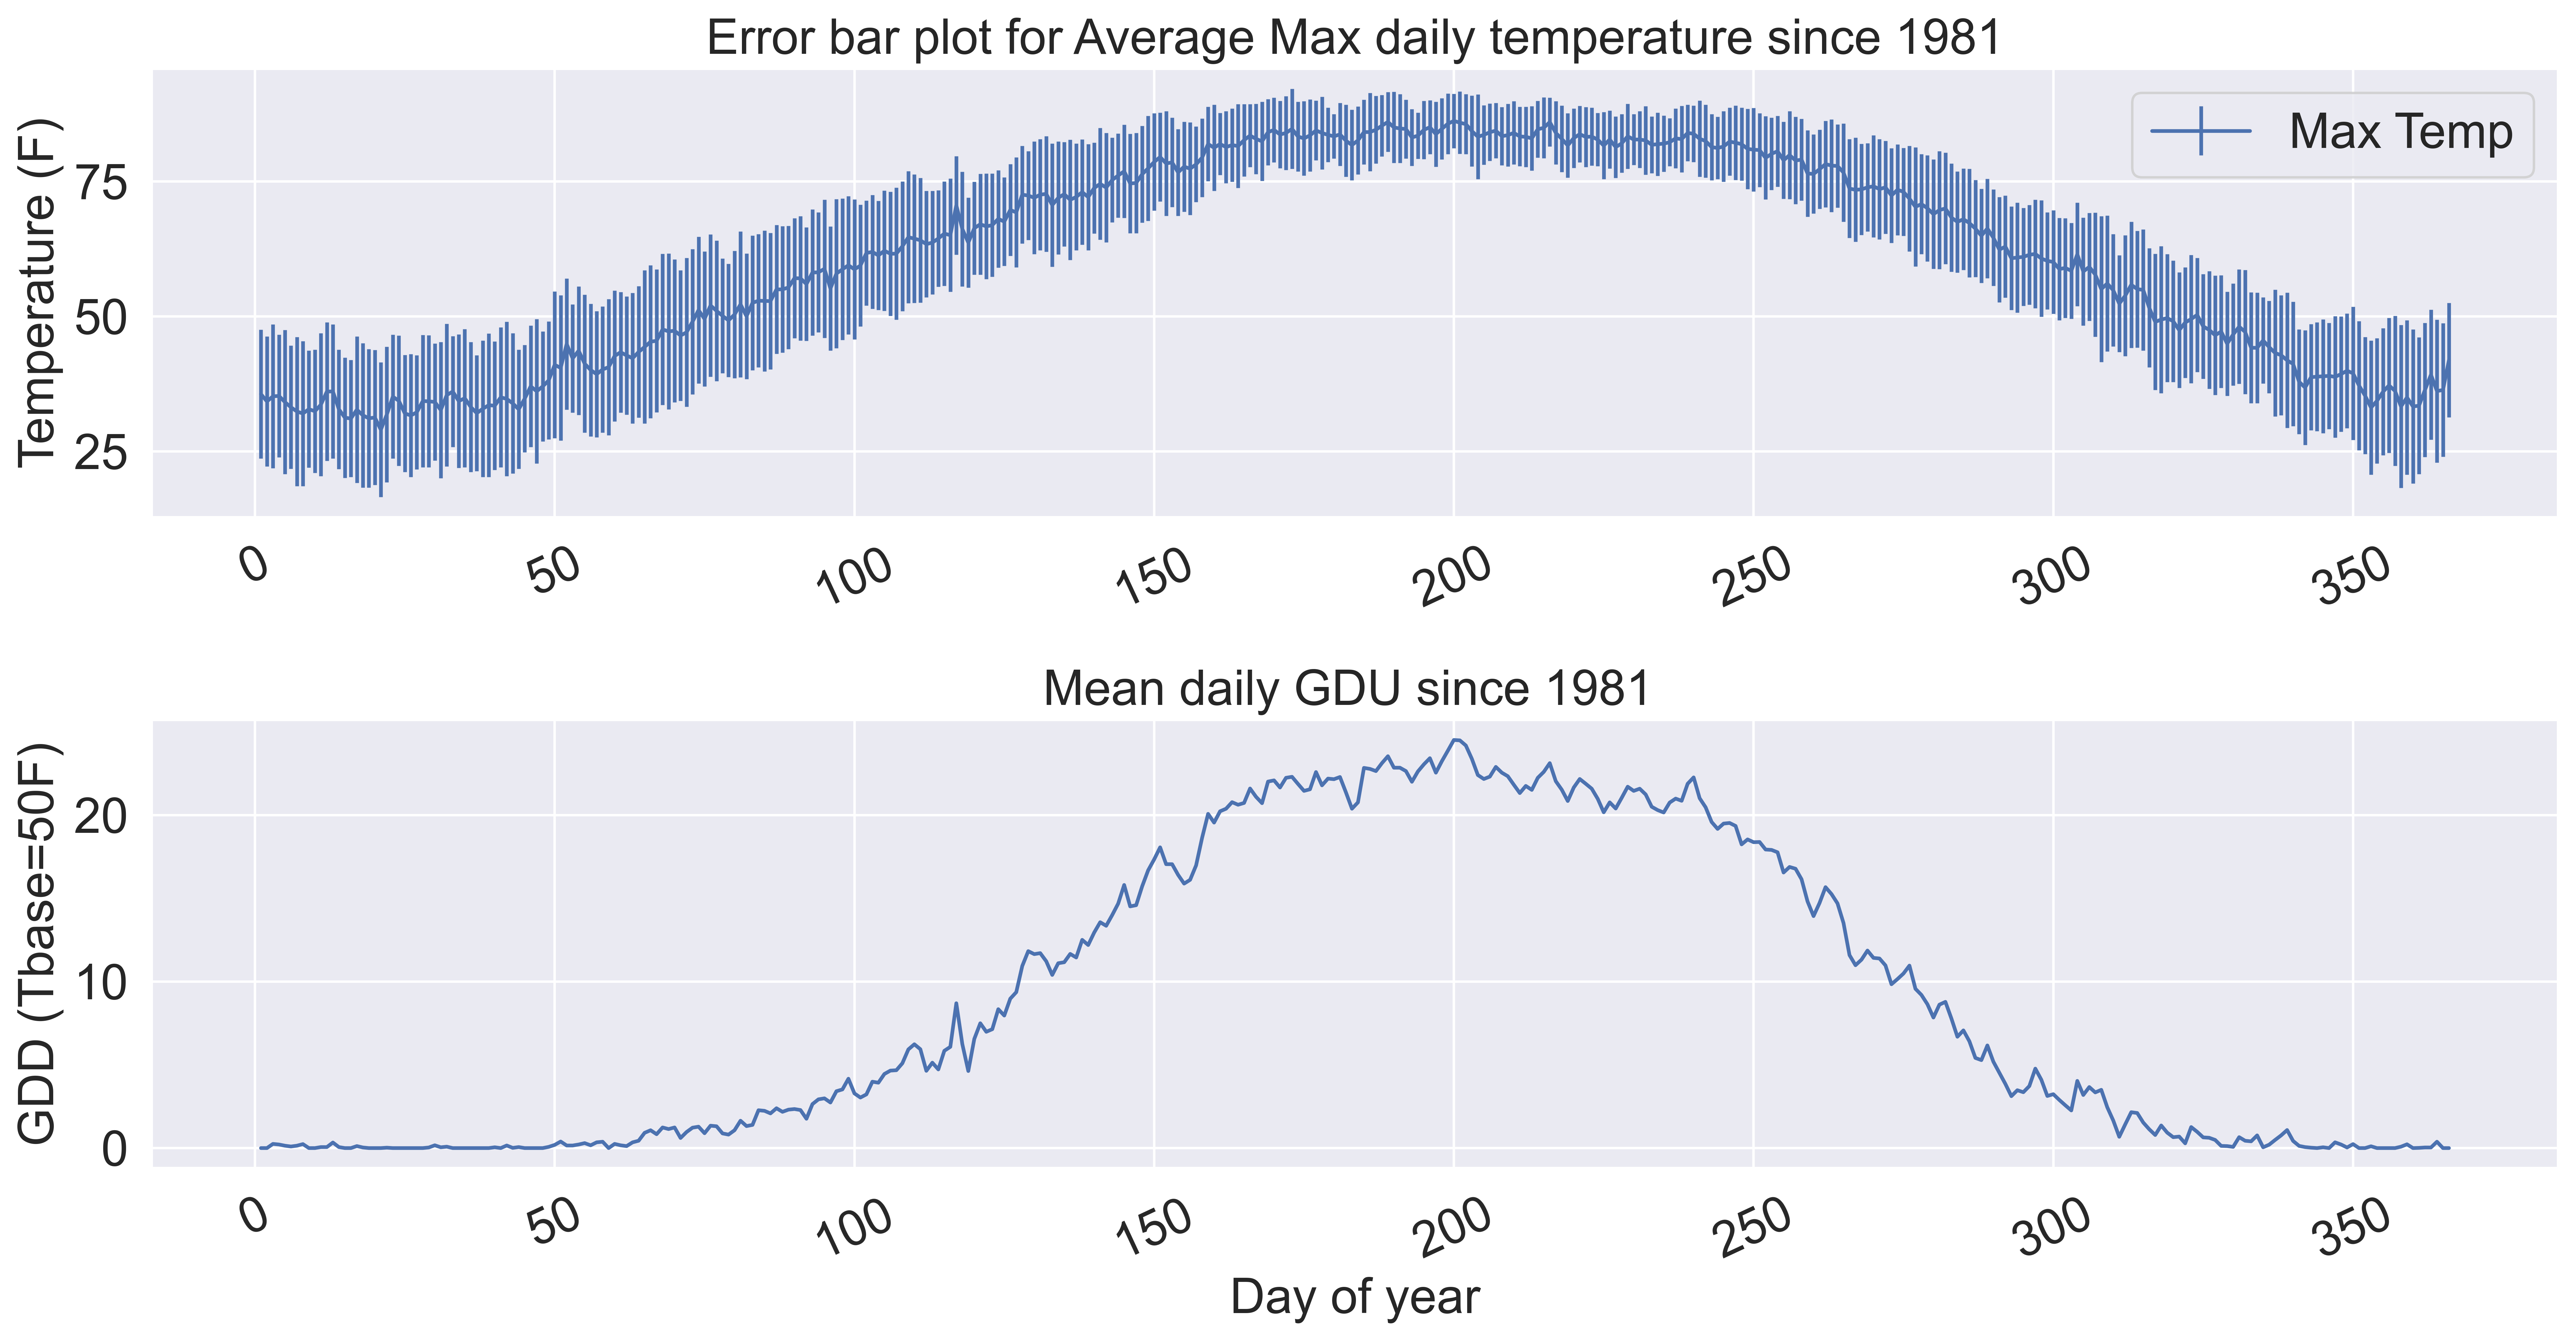

In [39]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] =600
# You can select a column out of the "GroupBy" before processing them
# You can use the resulting DataFrame just like before, e.g., plotting.
ax = plt.subplot(2, 1, 1)
plt.errorbar(byDay.groups.keys(), byDay.maxt.mean(), byDay.maxt.std())
plt.legend(['Max Temp', 'Min Temp'])
plt.ylabel('Temperature (F)')
plt.title('Error bar plot for Average Max daily temperature since 1981')
plt.xticks(rotation=25)

# Now we select the second slice. Notice we share the x-axis. This is so when you interact with the either plot
# the other plot is automatically adjusted to the same scale.
plt.subplot(2, 1, 2, sharex=ax)
plt.plot(byDay.groups.keys(), byDay.gdu.mean())
plt.ylabel('GDD (Tbase=50F)')
plt.xticks(rotation=25)


plt.xlabel('Day of year')
plt.title('Mean daily GDU since 1981 ')

plt.tight_layout()
plt.show()

#### *Discussion 5*:  Ag Data Analysis II 


**Estimating the current growth stage**  

*formulas used to calulcate the vegetative state and reproductive state:*

$V = 42 \frac{GDU}{GDU_\textrm{silking}} - 2.23$

$R = 10.3 \frac{GDU}{GDU_\textrm{black}} - 4.37$

In [40]:
def vgd(gdd, gdu_to_silking):

    Vgd_val = 42 * (gdd / gdu_to_silking) - 2.23
    return Vgd_val

def rgd(gdd,gdu_to_black):
    Rgd_val = 10.3 * (gdd / gdu_to_black) - 4.37
    return Rgd_val

# Note: A "negative" R indicates that the plant is not yet in the reproductive stage.
#print(f"V: {V}, R: {R}")

In [50]:
gdu_to_black = 2666
gdu_to_silking = 1372
# byDate_df_max["vgd"]=byDate_df_max.gdu_cumsum.apply(lambda x:vgd(x,gdu_to_silking))
# byDate_df_max["rgd"]=byDate_df_max.gdu_cumsum.apply(lambda x:rgd(x,gdu_to_black))
byDate_df_mean["rgd"]=byDate_df_mean.gdu_cumsum.apply(lambda x:rgd(x,gdu_to_black))
byDate_df_mean["vgd"]=byDate_df_mean.gdu_cumsum.apply(lambda x:vgd(x,gdu_to_silking))



#series["rgd"]=w["gdd_avg"].apply(lambda x:rgd(x,gdu_to_black))


C:\Users\jha16admin\AppData\Local\Temp\ipykernel_28916\616464387.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  byDate_df_mean_135["rgd"]=byDate_df_mean_135.gdu_cumsum.apply(lambda x:rgd(x,gdu_to_black))
C:\Users\jha16admin\AppData\Local\Temp\ipykernel_28916\616464387.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  byDate_df_mean_135["vgd"]=byDate_df_mean_135.gdu_cumsum.apply(lambda x:vgd(x,gdu_to_silking))


In [52]:
byDate_df_mean["rgd"]= np.ma.masked_where(byDate_df_mean["rgd"]<0.0, byDate_df_mean["rgd"])
byDate_df_mean["vgd"]= np.ma.masked_where(byDate_df_mean["vgd"]<0.0, byDate_df_mean["vgd"])



C:\Users\jha16admin\AppData\Local\Temp\ipykernel_28916\4211315008.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  byDate_df_mean_135["rgd"]= np.ma.masked_where(byDate_df_mean_135["rgd"]<0.0, byDate_df_mean_135["rgd"])
C:\Users\jha16admin\AppData\Local\Temp\ipykernel_28916\4211315008.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  byDate_df_mean_135["vgd"]= np.ma.masked_where(byDate_df_mean_135["vgd"]<0.0, byDate_df_mean_135["vgd"])


In [53]:
byDate_df_mean.describe()

d:\OneDrive - purdue.edu\AutomatingAgFieldTrials\Summer2023\HEC_Paper\ASABEPaperPythonTutorial-mainVersion2\.venv\Lib\site-packages\numpy\lib\function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
d:\OneDrive - purdue.edu\AutomatingAgFieldTrials\Summer2023\HEC_Paper\ASABEPaperPythonTutorial-mainVersion2\.venv\Lib\site-packages\numpy\lib\function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
d:\OneDrive - purdue.edu\AutomatingAgFieldTrials\Summer2023\HEC_Paper\ASABEPaperPythonTutorial-mainVersion2\.venv\Lib\site-packages\numpy\lib\function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
d:\OneDrive - purdue.edu\AutomatingAgFieldTrials\Summer2023\HEC_Paper\ASABEPaperPythonTutorial-mainVersion2\.venv\Lib\site-packages\numpy\lib\function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' o

maxt        mint         gdu        pcpn   gdu_cumsum  \
count  231.000000  231.000000  220.000000  231.000000   220.000000   
mean    69.012760   48.406432   13.144426    0.114778  2234.761201   
std     16.706674   14.738129    8.734591    0.051143   978.317739   
min     33.095238   16.047619    0.011905    0.021905   334.559524   
25%     55.976190   35.940476    3.354167    0.078929  1379.916667   
50%     76.642857   53.928571   15.851190    0.109762  2573.398810   
75%     82.857143   61.511905   21.464286    0.149167  3160.520833   
max     86.214286   66.452381   24.523810    0.326905  3214.666667   

              rgd         vgd  
count  176.000000  220.000000  
mean     5.759026   66.181057  
std      2.535770   29.948502  
min      0.034811    8.011618  
25%      3.829804   40.012347  
50%      6.938434   76.547515  
75%      7.956020   94.520638  
max      8.049755   96.178163

In [54]:
byDate_df_mean.head()

maxt       mint        gdu      pcpn  gdu_cumsum  rgd       vgd
date                                                                      
136   71.595238  51.119048  11.666667  0.190000  334.559524  NaN  8.011618
137   72.119048  50.785714  11.452381  0.128095  346.011905  NaN  8.362201
138   73.023810  51.642857  12.511905  0.135952  358.523810  NaN  8.745219
139   72.095238  52.071429  12.202381  0.124762  370.726190  NaN  9.118761
140   73.785714  52.190476  12.952381  0.135714  383.678571  NaN  9.515262

In [44]:
byDate_df_mean.to_excel("byDate_df_mean.xlsx")

ModuleNotFoundError: No module named 'openpyxl'

**Want to explore more about Corn GDD in the US?**   
visit [U2U tool to visualize GDD](https://hprcc.unl.edu/agroclimate/gdd.php)

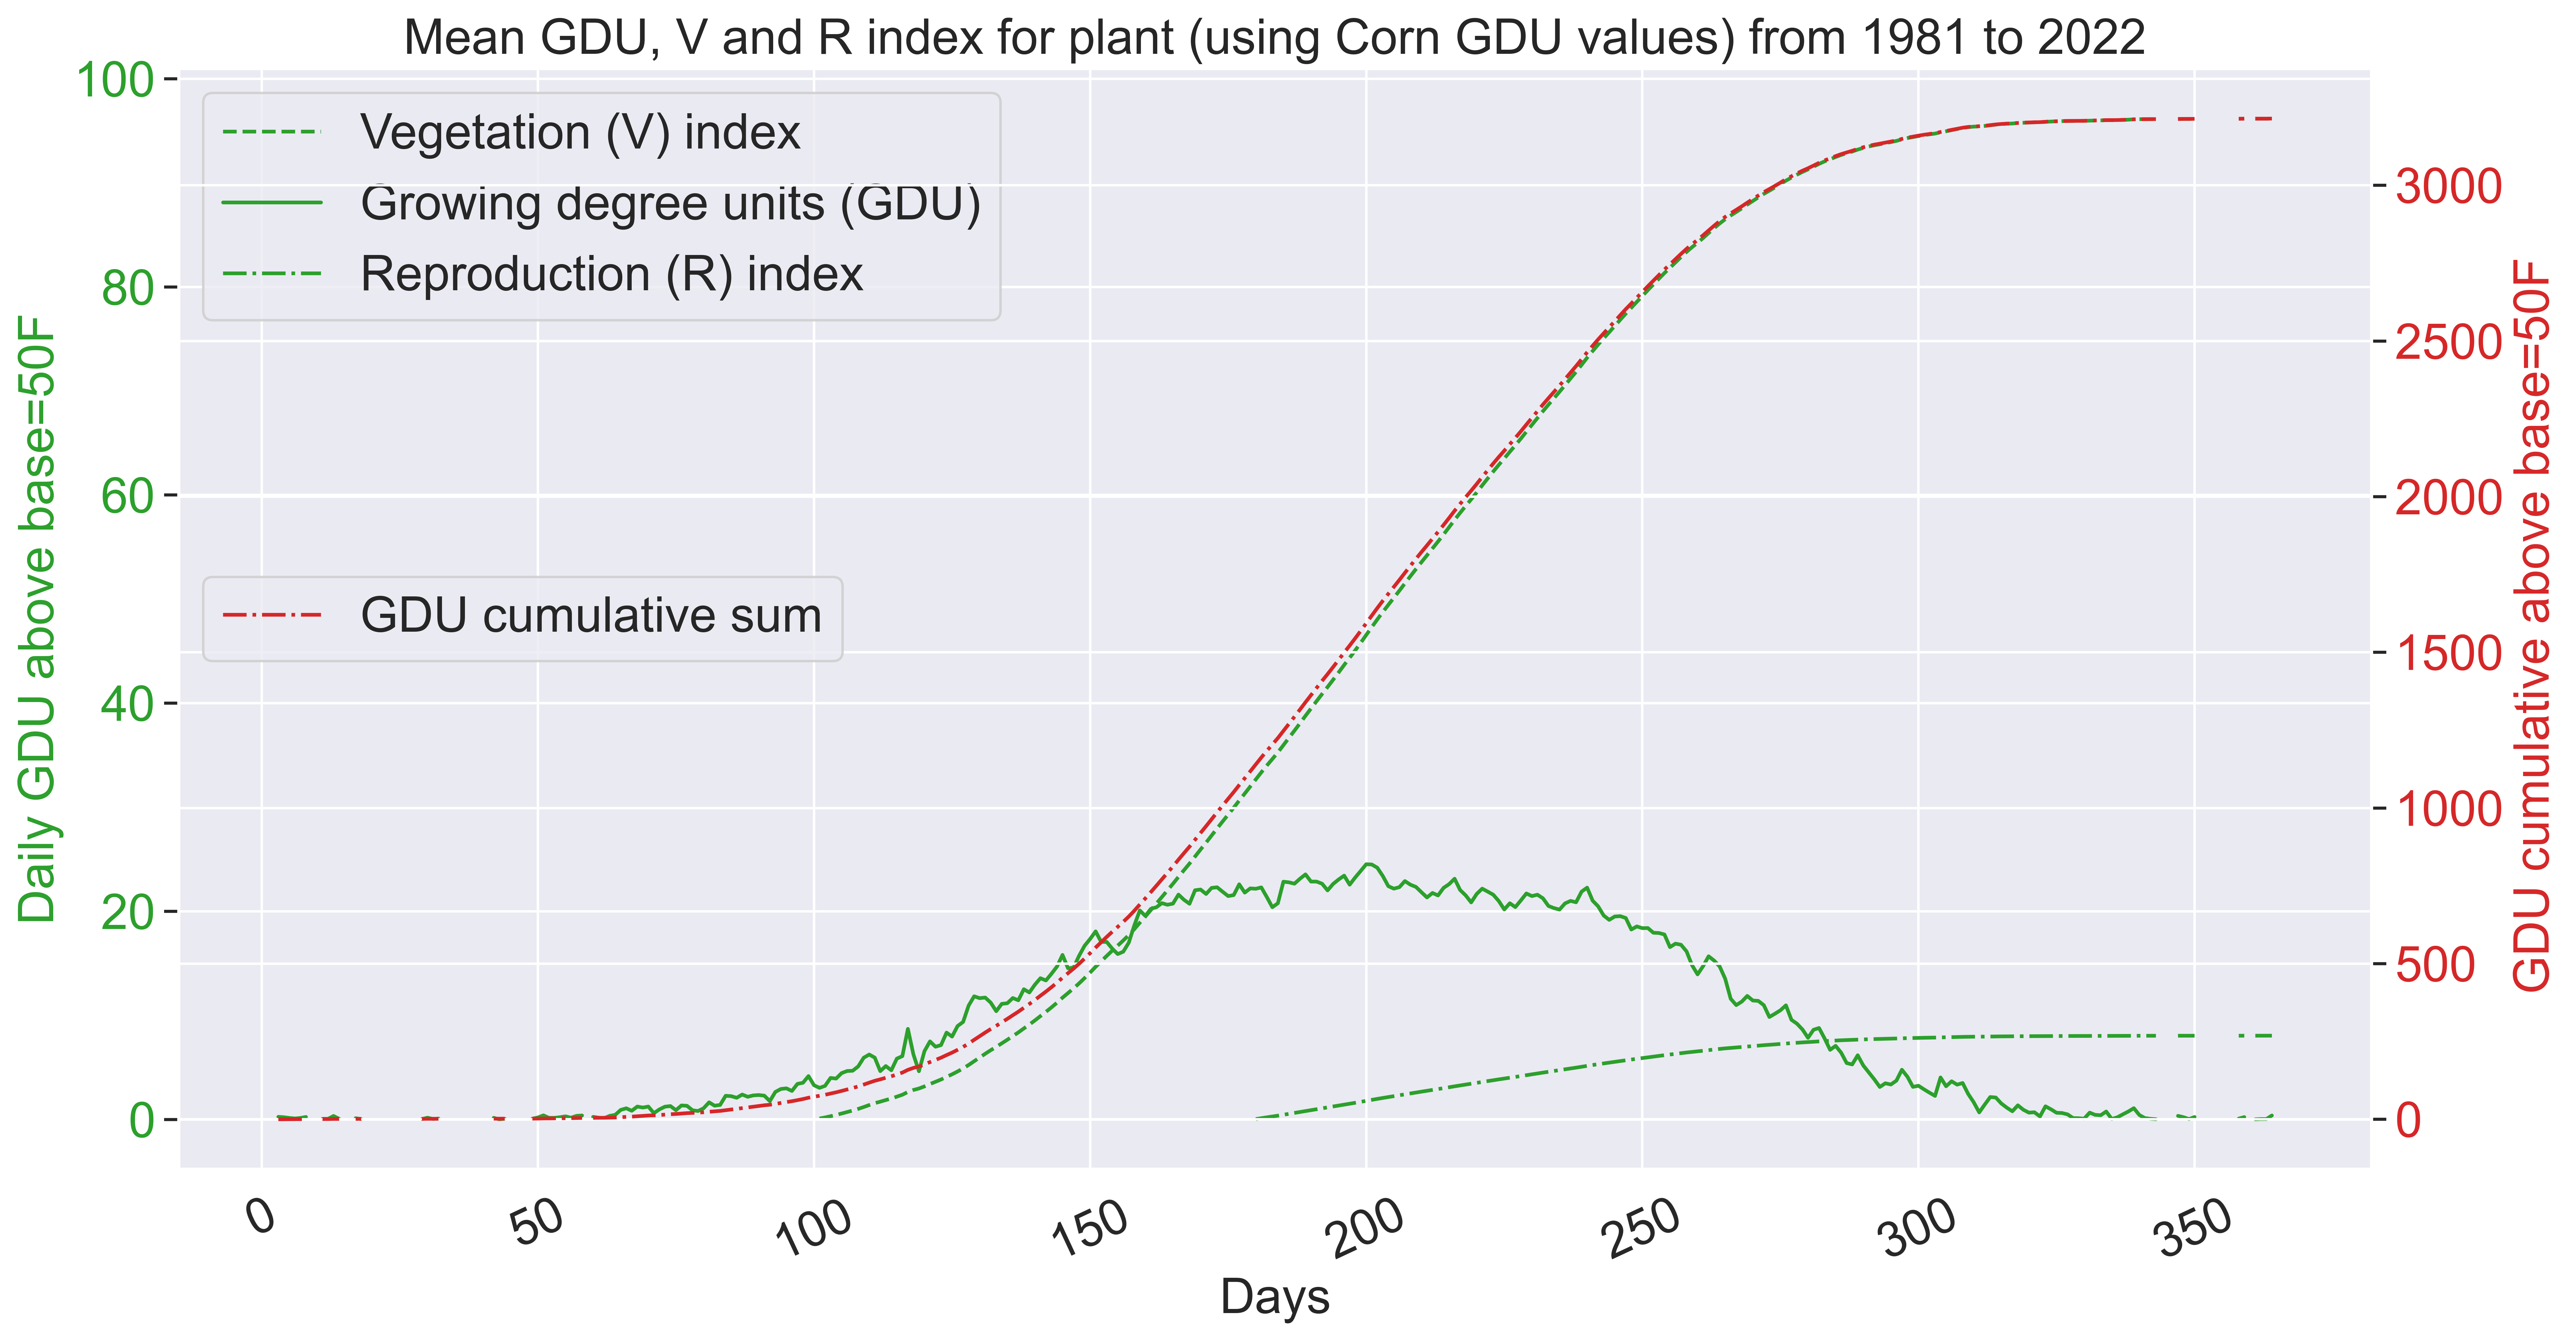

In [46]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600
fig, ax=plt.subplots()
ax1=ax
plt.title('Mean GDU, V and R index for plant (using Corn GDU values) from 1981 to 2022')
plt.xticks(rotation=25)
ax.set_xlabel('Days')
color='tab:green'
ax.plot(byDate_df_mean.vgd, linestyle="--", color= color)
ax.plot(byDate_df_mean.gdu, linestyle="-", color=color)
ax.plot(byDate_df_mean.rgd, linestyle="-.", color=color)
ax.legend(['Vegetation (V) index','Growing degree units (GDU)', 'Reproduction (R) index',], loc="upper left")
ax.set_ylabel('Daily GDU above base=50F', color=color)
ax.tick_params(axis='y', labelcolor=color)
ax1 = ax.twinx()
# We can improve the plot by adding labels, title, and tick rotation (the date strings are long)
color='tab:red'
ax1.plot(byDate_df_mean.gdu_cumsum, linestyle="-.",color=color)
ax1.legend(['GDU cumulative sum'], loc="center left")
ax1.set_ylabel('GDU cumulative above base=50F ', color=color)
ax1.tick_params(axis='y',labelcolor=color)

# A "tight layout" just reduces the amount of white space in the figure. A bit noisier but also larger plots.
fig.tight_layout()
plt.show()

In [164]:
# Save the daily GDU totals back to the DataFrame as a new col
listofDFs = []
def plantGrowth(year):
    w_copy=pd.DataFrame()
    wplantGrowth["gdu"]=0.0

    w_copy = wplantGrowth.loc[wplantGrowth.index.year==year]
    w_copy=w_copy.reset_index()
    #print(w_copy.head())
    for i in range(0, w_copy.shape[0]):
        #print(w_copy.loc[i,"maxt"])
        print("gdu sum",w_copy["gdu"].sum())
        if i<135:
            w_copy.loc[i, 'gdu'] = 0.0
        elif i>=135 and w_copy["gdu"].sum()<=gdu_to_silking:
            w_copy.loc[i, 'gdu'] = (w_copy.loc[i, 'maxt'] + w_copy.loc[i,'mint']) / 2 - t_base
        elif i>=135 and w_copy["gdu"].sum()> gdu_to_silking and w_copy["gdu"].sum()<=gdu_to_black:
            w_copy.loc[i, 'gdu'] = (w_copy.loc[i, 'maxt'] + w_copy.loc[i,'mint']) / 2 - t_base
        else:
            w_copy.loc[i, 'gdu'] = 0.0

    w_copy['gdu_cumsum'] =w_copy["gdu"].cumsum()
    w_copy["rgd"]=w_copy.gdu_cumsum.apply(lambda x:rgd(x,gdu_to_black))
    w_copy["vgd"]=w_copy.gdu_cumsum.apply(lambda x:vgd(x,gdu_to_silking))
    return w_copy



In [124]:
w.head()

maxt  mint  pcpn  maxt_gd  mint_gd  gdu
date                                               
1981-01-01    34    30   0.0       34       30  0.0
1981-01-02    33    18   0.0       33       18  0.0
1981-01-03    32    18   0.0       32       18  0.0
1981-01-04    24    -2   0.0       24       -2  0.0
1981-01-05    13    -3   0.0       13       -3  0.0

In [165]:
wd=wplantGrowth.reset_index()
print(wd.head())
for i in range(0, 4):
        
        print("check",i)
        if i<2:
            print(wd.loc[i, 'pcpn'])
        else:
              print(":P")


        date  maxt  mint  pcpn  gdu
0 1981-01-01    34    30   0.0  0.0
1 1981-01-02    33    18   0.0  0.0
2 1981-01-03    32    18   0.0  0.0
3 1981-01-04    24    -2   0.0  0.0
4 1981-01-05    13    -3   0.0  0.0
check 0
0.0
check 1
0.0
check 2
:P
check 3
:P


In [136]:
wplantGrowth["gdu"]=0.0
wplantGrowth.head()

maxt  mint  pcpn  gdu
date                             
1981-01-01    34    30   0.0  0.0
1981-01-02    33    18   0.0  0.0
1981-01-03    32    18   0.0  0.0
1981-01-04    24    -2   0.0  0.0
1981-01-05    13    -3   0.0  0.0

In [139]:
for year in wplantGrowth.index.year.unique():
    df=plantGrowth(year)
    listofDFs.append(df)
plantGrowth_df=pd.concat(listofDFs)
    


gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu sum 0.0
gdu 

In [140]:
plantGrowth_df["rgd"]= np.ma.masked_where(plantGrowth_df["rgd"]<0.0, plantGrowth_df["rgd"])
plantGrowth_df["vgd"]= np.ma.masked_where(plantGrowth_df["vgd"]<0.0, plantGrowth_df["vgd"])
plantGrowth_df["gdu"]= np.ma.masked_where(plantGrowth_df["gdu"]<0.0, plantGrowth_df["gdu"])


In [141]:
plantGrowth_df.head()

date  maxt  mint  pcpn  gdu  gdu_cumsum  rgd  vgd
0 1981-01-01    34    30   0.0  0.0         0.0  NaN  NaN
1 1981-01-02    33    18   0.0  0.0         0.0  NaN  NaN
2 1981-01-03    32    18   0.0  0.0         0.0  NaN  NaN
3 1981-01-04    24    -2   0.0  0.0         0.0  NaN  NaN
4 1981-01-05    13    -3   0.0  0.0         0.0  NaN  NaN

In [142]:
plantGrowth_df['date'] = pd.to_datetime(plantGrowth_df['date'])
plantGrowth_df.set_index('date', inplace=True)


In [143]:
byDayPlantgrowth = plantGrowth_df.groupby(plantGrowth_df.index.dayofyear)
byDate_df_mean_plantGrowth=pd.concat([byDayPlantgrowth.maxt.mean(), byDayPlantgrowth.mint.mean(), byDayPlantgrowth.gdu.mean(),byDayPlantgrowth.pcpn.mean(),byDayPlantgrowth.rgd.mean(),byDayPlantgrowth.vgd.mean(), byDayPlantgrowth.gdu_cumsum.mean()], axis='columns')

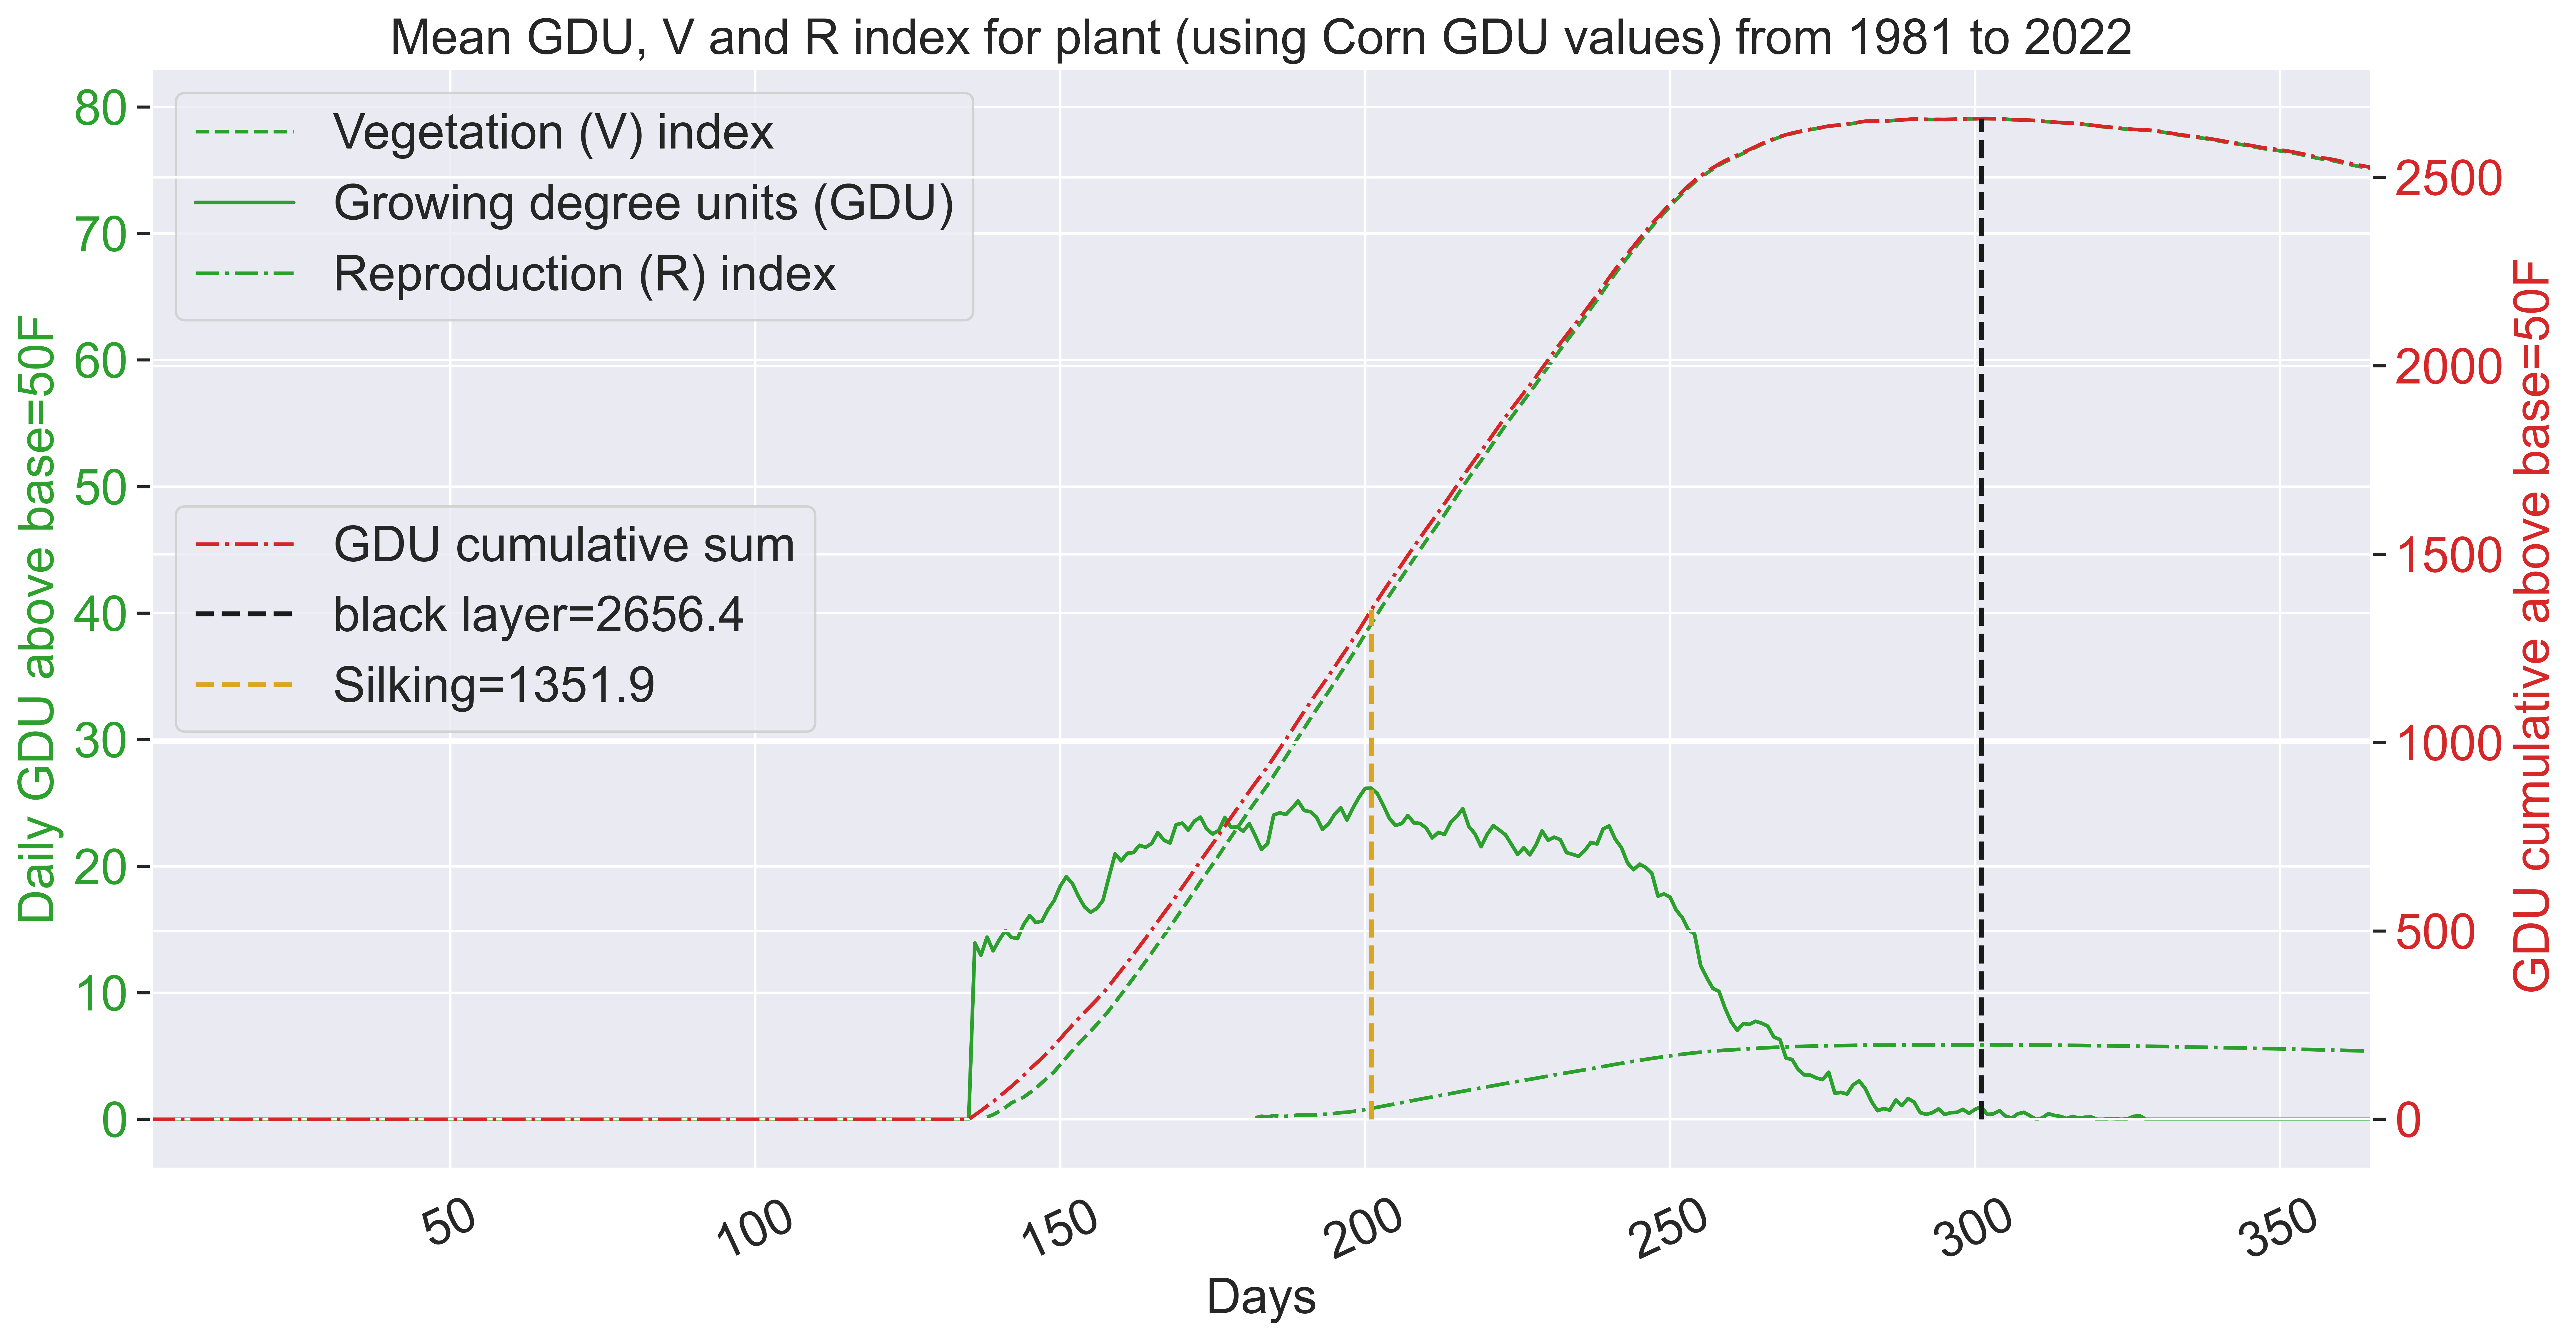

In [163]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600
fig, ax=plt.subplots()
ax1=ax
gdutoblackActual=byDate_df_mean_plantGrowth.loc[(byDate_df_mean_plantGrowth['gdu_cumsum']-gdu_to_black).abs().argsort()[:2],"gdu_cumsum"].max()
gdutosilkingActual=byDate_df_mean_plantGrowth.loc[(byDate_df_mean_plantGrowth['gdu_cumsum']-gdu_to_silking).abs().argsort()[:2],"gdu_cumsum"].max()

plt.title('Mean GDU, V and R index for plant (using Corn GDU values) from 1981 to 2022')
plt.xticks(rotation=25)
ax.set_xlabel('Days')
plt.xlim(1,365)
color='tab:green'
ax.plot(byDate_df_mean_plantGrowth.vgd, linestyle="--", color= color)
ax.plot(byDate_df_mean_plantGrowth.gdu, linestyle="-", color=color)
ax.plot(byDate_df_mean_plantGrowth.rgd, linestyle="-.", color=color)
ax.legend(['Vegetation (V) index','Growing degree units (GDU)', 'Reproduction (R) index',], loc="upper left")
ax.set_ylabel('Daily GDU above base=50F', color=color)
ax.tick_params(axis='y', labelcolor=color)
ax1 = ax.twinx()
# We can improve the plot by adding labels, title, and tick rotation (the date strings are long)
color='tab:red'
ax1.plot(byDate_df_mean_plantGrowth.gdu_cumsum, linestyle="-.",color=color, label="GDU cumulative sum")
ax1.set_ylabel('GDU cumulative above base=50F ', color=color)
ax1.tick_params(axis='y',labelcolor=color)
plt.vlines(x=byDate_df_mean_plantGrowth.index[byDate_df_mean_plantGrowth["gdu_cumsum"]==gdutoblackActual], ymin=0, ymax=gdutoblackActual, color='k', linestyle='--', linewidth=2, label="black layer="+str(round(gdutoblackActual,1)))
plt.vlines(x=byDate_df_mean_plantGrowth.index[byDate_df_mean_plantGrowth["gdu_cumsum"]==gdutosilkingActual], ymin=0, ymax=gdutosilkingActual, color='goldenrod', linestyle='--', linewidth=2, label="Silking="+str(round(gdutosilkingActual,1)))

# A "tight layout" just reduces the amount of white space in the figure. A bit noisier but also larger plots.
ax1.legend(loc="center left")
fig.tight_layout()
plt.show()

**Combining DataFrame and GroupBy data on one plot**  

Display the average minimum and maximum temperatures over the 2020 data.

In [ ]:
w20 = w['2020-01-01':'2020-12-31']
plt.plot(w20.maxt, 'b.')
plt.plot(w20.mint, 'g.')
plt.plot(w20.index, byDay.maxt.mean(), 'k')
plt.plot(w20.index, byDay.mint.mean(), 'k')

plt.legend(['Max T', 'Min T'])
plt.ylabel('Temperature (F)')
plt.title('Temperature over time')
plt.xticks(rotation=25)

plt.tight_layout()
plt.show()